In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn import preprocessing, decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm

In [2]:
data_2015 = pd.read_csv("archive/2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv("archive/2016-building-energy-benchmarking.csv")

In [3]:
def introduce_data(data, nom_data):
    """Affiche les dimensions d'une base de données"""
    print("La base de données %s contient %d lignes et %d colonnes" % (nom_data, len(data), len(data.columns)))

In [4]:
introduce_data(data_2015, "de 2015")

La base de données de 2015 contient 3340 lignes et 47 colonnes


In [5]:
introduce_data(data_2016, "de 2016")

La base de données de 2016 contient 3376 lignes et 46 colonnes


On observe une **différence dans le nombre de colonnes**, qu'il faudra corriger.

# Nettoyage

## Doublons

In [6]:
def count_duplicates(data, nom_data, key):
    nb_duplicates = len(data) - len(data.drop_duplicates(subset=[key]))
    print("La base de données %s contient %d doublons" % (nom_data, nb_duplicates))

In [7]:
count_duplicates(data_2015, "de 2015", "OSEBuildingID")

La base de données de 2015 contient 0 doublons


In [8]:
count_duplicates(data_2016, "de 2016", "OSEBuildingID")

La base de données de 2016 contient 0 doublons


## Différences entre les colonnes des bases de données

In [9]:
def columns_diff(data1, data2, nom_data1, nom_data2):
    """Affiche les colonnes d'une base de donnée qui ne sont pas dans une autre"""
    # cols_in_1_notin_2: Les colonnes de data1 qui sont pas dans celles de data2
    cols_in_1_notin_2 = data1.columns.difference(data2.columns)
    print("Les variables de %s qui ne sont pas dans %s:\n%s" % (nom_data1, nom_data2, cols_in_1_notin_2))

Voyons quelles sont les colonnes concernées:

In [10]:
columns_diff(data_2016, data_2015, "l'année 2016", "celles de l'année 2015")

Les variables de l'année 2016 qui ne sont pas dans celles de l'année 2015:
Index(['Address', 'City', 'Comments', 'GHGEmissionsIntensity', 'Latitude',
       'Longitude', 'State', 'TotalGHGEmissions', 'ZipCode'],
      dtype='object')


In [11]:
columns_diff(data_2015, data_2016, "l'année 2015", "celles de l'année 2016")

Les variables de l'année 2015 qui ne sont pas dans celles de l'année 2016:
Index(['2010 Census Tracts', 'City Council Districts', 'Comment',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'Location', 'OtherFuelUse(kBtu)', 'SPD Beats',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'Zip Codes'],
      dtype='object')


## Formattage des colonnes

Certaines colonnes ont des noms différents mais contiennent les mêmes variables. On corrige cela.

Ici, pour l'intensité des émissions des gazs à effet de serre, l'unité est affichée sur pour une colonne mais pas pour l'autre.

In [12]:
data_2015.columns = data_2015.columns.where(data_2015.columns != 'GHGEmissionsIntensity(kgCO2e/ft2)', 'GHGEmissionsIntensity')

Pour la quantité totale de gazs à effet de serre émis, on fait la même remarque que précédemment.

In [13]:
data_2015.columns = data_2015.columns.where(data_2015.columns != 'GHGEmissions(MetricTonsCO2e)', 'TotalGHGEmissions')

Pour les variables des commentaires, il y à juste une différence d'orthographe.

In [14]:
data_2015.columns = data_2015.columns.where(data_2015.columns != 'Comment', 'Comments')

Dans les données de 2015, **la variable 'Location' contient plusieurs variables qui sont dispatchées dans les données de 2016***, comme on peut le constater ci-dessous:

In [15]:
# Exemple de contenu de la variable 'Location'
data_2015['Location'].iloc[0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

On va donc **répartir la variable 'Location' dans plusieurs variables** pour harmoniser les bases de données. On fait liste ces variables et leur ordre d'apparition dans le dictionnaire suivant:

In [16]:
# index_var_in_location: Contient l'ordre d'apparition des sous-variables dans 'Location'
index_var_in_location = {
    'Latitude': 0,
    'Longitude': 1,
    'Address': 2,
    'City': 3,
    'State': 4,
    'ZipCode': 5
}

On commence par séparer les sous-variables dans 'Location' dans une liste, en enlevant les caractères gênant le traitement (\' ou  \"  etc...)

In [17]:
def vars_from_location(location):
    """Transforme une valeurs de la variable 'Location' en une liste de valeurs de variables en les formattant."""
    location = location.replace("\'", "").replace('\"', "").replace("}", "")
    # location_split: Contient les variables contenue dans location séparées dans une liste
    location_split = location.split(',')
    # Les éléments de value split sont sous la forme "nom_var: valeur var" ...
    # ... Sauf pour le 3ème élément qui est sous la forme "human_adress: {adress: une_adresse_x"
    # Corrigeons cela:
    location_split[2] = location_split[2].split('{')[1]
    # Reste à supprimer les noms de variable dans chaque élément pour garder juste la valeur
    for index_var in range(len(location_split)):
        location_split[index_var] = location_split[index_var].split(':')[1]
    return location_split

Essayons cette fonction sur un exemple.

In [18]:
value_location = data_2015['Location'].iloc[0]
print("Valeur de 'Location' prise en exemple:\n%s" % value_location)
print("\nTransformation de cette valeur avec la fonction vars_from_location:\n%s" % vars_from_location(value_location))

Valeur de 'Location' prise en exemple:
{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}

Transformation de cette valeur avec la fonction vars_from_location:
[' 47.61219025', ' -122.33799744', ' 405 OLIVE WAY', ' SEATTLE', ' WA', ' 98101']


On applique donc cette fonction sur la base de donnée de 2015.

In [19]:
data_2015['Location'] = data_2015['Location'].map(vars_from_location)

À présent, il reste à extraire de la variable 'Location' les valeurs de chacune de nos variables.

On crée les colonnes de chaque nouvelle variable, et on supprime celle de 'Location'

In [20]:
for var_name, ind_var in index_var_in_location.items():
    # var_name, ind_var: Variable à ajouter dans data_2015, et son indice dans la colonne 'Location'
    data_2015[var_name] = data_2015['Location'].map(lambda vars_list: vars_list[ind_var])
# On a plus besoin de la variable 'Location': On la supprime
data_2015 = data_2015.drop(columns=['Location'])

On caste la latitude et la longitude en flottants (car ce sont des strings pour l'instant):

In [21]:
# to_cast_float: Nom d'une variable à caster en flottant
for to_cast_float in ['Latitude', 'Longitude']:
    data_2015[to_cast_float] = data_2015[to_cast_float].astype(float) 

Pour les variables qui n'ont toujours pas de correspondance, on va simplement les ignorer.

In [22]:
data_2015 = data_2015.drop(columns=data_2015.columns.difference(data_2016.columns))

## Valeurs aberrantes
Notre modèle doit s'appuyer sur les **valeurs déclaratives du permis de construction**. C'est à dire, sur les données concernant le bâtiment, et pas sur les mesures de consommation d'énergie ou d'émissions. Les valeurs qu'on va utiliser sont les suivantes:
- YearBuilt
- NumberofBuildings
- NumberofFloors
- LargestPropertyUseType
- PropertyGFABuilding(s)
- Latitude
- Longitude

Il y à aussi les variables DefaultData, ComplianceStatus, Outlier, qu'on ne va pas utiliser car leurs définitions ne sont pas données.

On a aussi les **variables à prédire**:
- SiteEnergyUse(kBtu)
- TotalGHGEmissions

Et le **lien entre les émissions et cette variable**:
- ENERGYSTARScore

On va s'attacher à épurer nos bases de données des valeurs aberrantes pour chacune des variables citées précédemment.

### Fonctions utiles

On écrit quelques fonctions pour calculer et afficher les distributions des variables.

In [23]:
def distrib_discrete_var(data, var_name, to_count='OSEBuildingID'):
    """Retourne une série ayant en index les valeurs d'une variable et en contenu le nombre d'individus associé"""
    return data[[var_name, to_count]].groupby(var_name).count()[to_count]

In [24]:
# get_left_interval: Obtenir la borne inférieur d'un intervalle pandas
get_left_interval = lambda x: x.left
def distrib_continuous_var(data, var_name, bins,  dtype=float, to_count='OSEBuildingID'):
    """Discrétise une variable continue puis retourne sa distribution"""
    data_copy = data.copy()
    data_copy[var_name] = pd.cut(data_copy[var_name], bins)
    data_copy[var_name] = data_copy[var_name].map(get_left_interval)
    data_copy[var_name] = data_copy[var_name].astype(dtype)
    return distrib_discrete_var(data_copy, var_name, to_count)

In [25]:
def plot_distrib(distrib_axes, x_name, y_name, title, kwargs=None):
    """Affiche la distribution d'une variable dont les valeurs sont contenues dans une série"""
    kwargs = {} if kwargs is None else kwargs
    plt.bar(distrib_axes.index, distrib_axes, **kwargs)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(title)

### YearBuilt

Text(0.5, 1.0, "Diagramme en boite de l'année de construction")

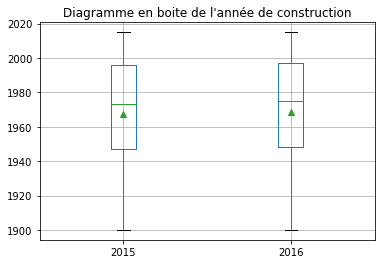

In [26]:
# data_yearbuilt: Chaque colonne contient les années de construction pour une base de données 
data_yearbuilt = pd.concat([data_2015['YearBuilt'], data_2016['YearBuilt']], axis=1)
data_yearbuilt.columns = ['2015', '2016']
data_yearbuilt.boxplot(showmeans=True)
plt.title("Diagramme en boite de l'année de construction")

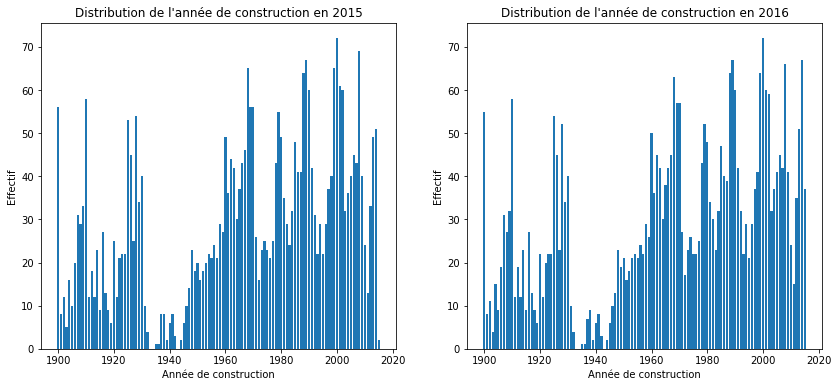

In [27]:
# distrib_yearbuilt_2015: Distribution de l'année de construction des bâtiments avec les données de 2015
distrib_yearbuilt_2015 = distrib_discrete_var(data_2015, 'YearBuilt')
plt.subplots(figsize=(14,6))
plt.subplot(1, 2, 1)
plot_distrib(distrib_yearbuilt_2015, "Année de construction", "Effectif", 
             "Distribution de l'année de construction en 2015")
plt.subplot(1, 2, 2)
# distrib_yearbuilt_2016: Distribution de l'année de construction des bâtiments avec les données de 2016
distrib_yearbuilt_2016 = distrib_discrete_var(data_2016, 'YearBuilt')
plot_distrib(distrib_yearbuilt_2016, "Année de construction", "Effectif",
             "Distribution de l'année de construction en 2016")

**Les valeurs ici sont cohérentes**: Pas de bâtiments construits 'dans le futur' ou il y à des centaines d'années. De plus les distributions ne changent pas beaucoup d'une année à l'autre. **On va donc conserver toutes les données**.

### NumberofBuildings

Text(0.5, 1.0, 'Diagramme en boite du nombre de bâtiments')

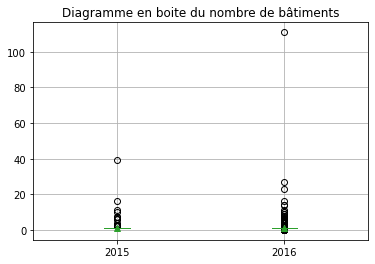

In [28]:
# data_nb_buildings: Chaque colonne contient les nombres de bâtiments pour une base de données 
data_nb_buildings = pd.concat([data_2015['NumberofBuildings'], data_2016['NumberofBuildings']], axis=1)
data_nb_buildings.columns = ['2015', '2016']
data_nb_buildings.boxplot(showmeans=True)
plt.title("Diagramme en boite du nombre de bâtiments")

Il semble que **la grande majoritée des propriétés contient un seul bâtiment**: La boîte du diagramme est concentrée en 1.    

On remarque **une propriété avec plus de 100 bâtiments**, ce qui paraît très improbable. Voyons de quel individu il s'agit.

In [29]:
# data_2016_sort_nb_buildings: Tri des données de 2016 selon le nombre de bâtiments
data_2016_sort_nb_buildings = data_2016.sort_values('NumberofBuildings', ascending=False)
# outlier_2016: La propriété avec le plus de bâtiments en 2016
outlier_2016 = data_2016_sort_nb_buildings.iloc[0]
print("L'outlier le plus déviant de 2016 est %s avec %d bâtiments" % \
      (outlier_2016['PropertyName'], outlier_2016['NumberofBuildings']))

L'outlier le plus déviant de 2016 est University of Washington - Seattle Campus avec 111 bâtiments


Cette valeur paraît aberrante. **On va ignorer cet individu**.

In [30]:
data_2016 = data_2016[data_2016['OSEBuildingID'] != outlier_2016['OSEBuildingID']]

On s'intéresse maintenant aux distributions du nombre de bâtiments.

(0.0, 10.0)

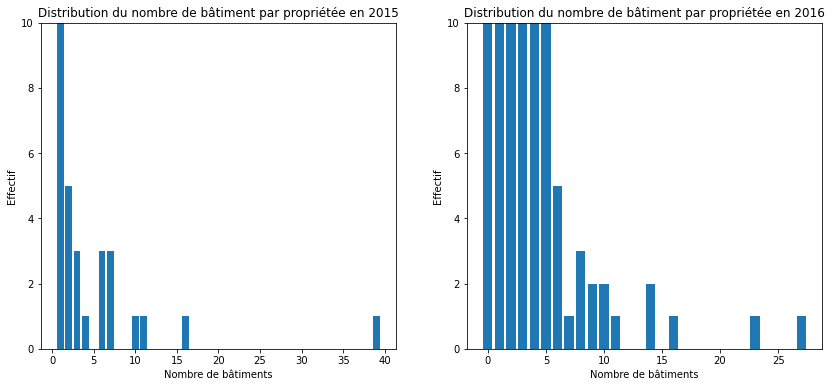

In [31]:
# distrib_nb_buildings_2015: Distribution du nombre de bâtiments avec les données de 2015
distrib_nb_buildings_2015 = distrib_discrete_var(data_2015, 'NumberofBuildings')
plt.subplots(figsize=(14,6))
plt.subplot(1, 2, 1)
plot_distrib(distrib_nb_buildings_2015, "Nombre de bâtiments", "Effectif", 
             "Distribution du nombre de bâtiment par propriétée en 2015")
plt.ylim(0, 10)  # Pour pouvoir observer les petits effectifs
plt.subplot(1, 2, 2)
# distrib_nb_buildings_2016: Distribution du nombre de bâtiments avec les données de 2016
distrib_nb_buildings_2016 = distrib_discrete_var(data_2016, 'NumberofBuildings')
plot_distrib(distrib_nb_buildings_2016, "Nombre de bâtiments", "Effectif",
             "Distribution du nombre de bâtiment par propriétée en 2016")
plt.ylim(0, 10)  # Pour pouvoir observer les petits effectifs

On voit qu'**il y à de nombreuses propriétés sans aucun bâtiment en 2016**. Voyons desquels il s'agit.

In [32]:
data_2016[data_2016['NumberofBuildings'] == 0].head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
63,89,2016,NonResidential,Medical Office,Polyclinic North && South,1200 Harvard Ave,Seattle,WA,98122.0,1978201270,...,2.897563e+06,9886484.0,68145.70313,6814570.0,False,NaN,Compliant,NaN,430.84,2.41
76,113,2016,NonResidential,Small- and Mid-Sized Office,KCTS9,401 Mercer St,Seattle,WA,98109.0,1988200705,...,1.221074e+06,4166305.0,0.00000,0.0,False,NaN,Compliant,NaN,29.04,0.44
160,257,2016,NonResidential,Warehouse,Harbor Island: Warehouse E - DNRP-SWD,3235 16TH AVE SW,Seattle,WA,98134.0,7666703020,...,7.067415e+05,2411402.0,0.00000,0.0,False,NaN,Compliant,NaN,16.81,0.21
201,322,2016,NonResidential,Large Office,Cox Media Group Seattle KIRO TV (322),2801 3rd Ave,Seattle,WA,98121.0,0656000005,...,2.868908e+06,9788716.0,0.00000,0.0,False,NaN,Compliant,NaN,68.24,0.68
241,366,2016,NonResidential,Small- and Mid-Sized Office,University District Office Buiding,1107 NE 45th St,Seattle,WA,98105.0,1142000500,...,8.391593e+05,2863212.0,18652.76563,1865277.0,False,NaN,Compliant,NaN,119.03,1.20


Ce sont des bureaux, des dépots... **On va ignorer ces individus**.

In [33]:
data_2016 = data_2016[data_2016['NumberofBuildings'] != 0]

Voyons maintenant s'il y à une **cohérence des données d'une année à l'autre**.

In [34]:
# data_nb_buildings_X: Nombre de bâtiments pour un identifiant OSE pour les bâtiments pour l'année X 
data_nb_buildings_16 = data_2016[['OSEBuildingID', 'NumberofBuildings']].set_index('OSEBuildingID')
data_nb_buildings_15 = data_2015[['OSEBuildingID', 'NumberofBuildings']].set_index('OSEBuildingID')
# data_nb_buildings: Jointure interne des bases de données des années 2015 et 2016 selon l'identifiant OSE
data_nb_buildings = data_nb_buildings_16.join(data_nb_buildings_15, how='inner', lsuffix='_2016', rsuffix='_2015')

# On calcule la différence en valeur absolue du nombre de bâtiments entre les 2 années dans la colonne 'difference'
data_nb_buildings['difference'] = data_nb_buildings['NumberofBuildings_2016']-data_nb_buildings['NumberofBuildings_2015']
data_nb_buildings['difference'] = data_nb_buildings['difference'].abs()  # On regarde la différence absolue

(0.0, 50.0)

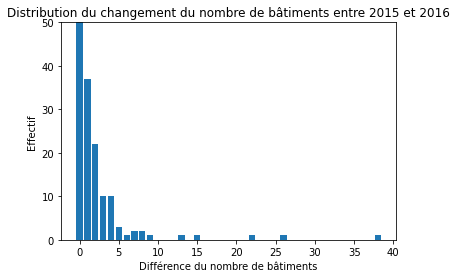

In [35]:
data_nb_buildings['OSEBuildingID'] = data_nb_buildings.index  # Pour utiliser count dans la fonction plot_distrib
# distrib_nb_buildings_diff: Distribution de la différence du nombre de bâtiments en 2015 et en 2016
distrib_nb_buildings_diff = distrib_discrete_var(data_nb_buildings, 'difference')
plot_distrib(distrib_nb_buildings_diff, "Différence du nombre de bâtiments", "Effectif", 
             "Distribution du changement du nombre de bâtiments entre 2015 et 2016")
plt.ylim(0,50)

**Les propriétés dont le nombre de bâtiments augmente ou diminue de plus de 5 seront ignorées**.

In [36]:
# id_outliers: Identifiants OSE des propriétés dont le nombre de bâtiment change trop d'une année à l'autre
id_outliers = data_nb_buildings[data_nb_buildings['difference']>5]['OSEBuildingID']
data_2015 = data_2015[~data_2015['OSEBuildingID'].isin(id_outliers)]
data_2016 = data_2016[~data_2016['OSEBuildingID'].isin(id_outliers)]

### NumberofFloors

Text(0.5, 1.0, "Diagramme en boite du nombre d'étages")

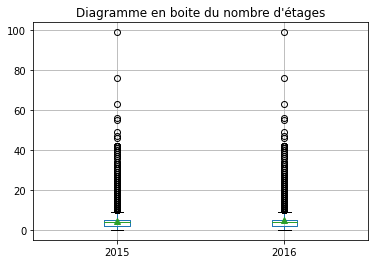

In [37]:
# data_nb_floors: Chaque colonne contient les nombres d'étages pour une base de données 
data_nb_floors = pd.concat([data_2015['NumberofFloors'], data_2016['NumberofFloors']], axis=1)
data_nb_floors.columns = ['2015', '2016']
data_nb_floors.boxplot(showmeans=True)
plt.title("Diagramme en boite du nombre d'étages")

On observe encore de nombreux outliers. **Voyons qui est l'individus le plus déviant** en 2015 et en 2016.

In [38]:
# data_2016_sort_nb_floors: Données de 2016 triés selon le nombre d'étages
data_2016_sort_nb_floors = data_2016.sort_values('NumberofFloors', ascending=False)
data_2016_sort_nb_floors.iloc[0:1]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1359,21611,2016,NonResidential,Worship Facility,Seattle Chinese Baptist Church,5801 Beacon Avenue South,Seattle,WA,98108.0,2124049098,...,95545.5,326001.0,0.0,0.0,False,NaN,Compliant,NaN,2.27,0.1


In [39]:
# data_2015_sort_nb_floors: Données de 2015 triés selon le nombre d'étages
data_2015_sort_nb_floors = data_2015.sort_values('NumberofFloors', ascending=False)
data_2015_sort_nb_floors.iloc[0:1]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
1371,21611,2015,NonResidential,Worship Facility,CHINESE BAPTIST CHURCH,2124049098,2,GREATER DUWAMISH,1977,1,...,Yes,NaN,Compliant,NaN,47.550571,-122.302943,5801 BEACON AVE S,SEATTLE,WA,98108


**Le bâtiment avec le plus d'étages est une église... Avec 100 étages**. Le plus haut bâtiment de Seattle fait 76 étages donc **on la supprime de nos données**.

In [40]:
data_2016 = data_2016[data_2016['OSEBuildingID'] != 21611]
data_2015 = data_2015[data_2015['OSEBuildingID'] != 21611]

On regarde à présent la **distribution du nombre d'étage** pour chaque année.

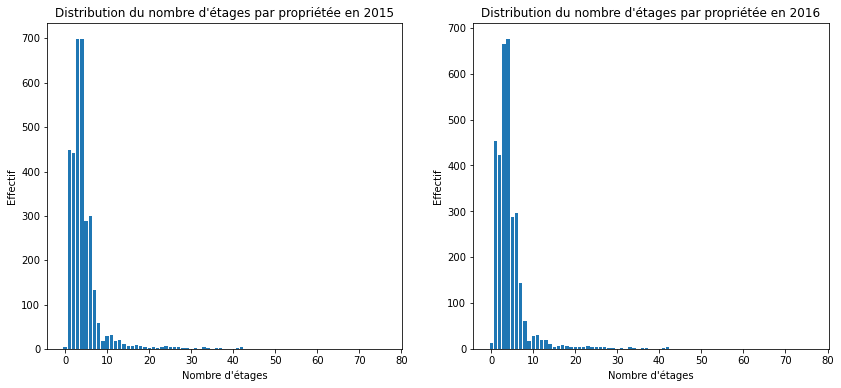

In [41]:
# distrib_nb_floors_2015: Distribution du nombre d'étages avec les données de 2015
distrib_nb_floors_2015 = distrib_discrete_var(data_2015, 'NumberofFloors')
plt.subplots(figsize=(14,6))
plt.subplot(1, 2, 1)
plot_distrib(distrib_nb_floors_2015, "Nombre d'étages", "Effectif", 
             "Distribution du nombre d'étages par propriétée en 2015")
plt.subplot(1, 2, 2)
# distrib_nb_floors_2016: Distribution du nombre d'étages avec les données de 2016
distrib_nb_floors_2016 = distrib_discrete_var(data_2016, 'NumberofFloors')
plot_distrib(distrib_nb_floors_2016, "Nombre d'étages", "Effectif",
             "Distribution du nombre d'étages par propriétée en 2016")

**On supprime les bâtiments qui n'ont pas du tout d'étage**, c'est à dire, qui n'ont pas de rez-de-chaussée !

In [42]:
data_2015 = data_2015[data_2015['NumberofFloors'] != 0]
data_2016 = data_2016[data_2016['NumberofFloors'] != 0]

On regarde à présent la différence d'une année sur l'autre pour les bâtiments présents dans les deux bases de données.

In [43]:
# data_nb_floors_X: Nombre d'étages pour un identifiant OSE pour l'année X
data_nb_floors_16 = data_2016[['OSEBuildingID', 'NumberofFloors']].set_index('OSEBuildingID')
data_nb_floors_15 = data_2015[['OSEBuildingID', 'NumberofFloors']].set_index('OSEBuildingID')
# data_nb_floors: Jointure interne des précédentes bases de données selon l'identifiant OSE 
data_nb_floors = data_nb_floors_16.join(data_nb_floors_15, how='inner', lsuffix='_2016', rsuffix='_2015')
# On calcule la différence en valeur absolue du nombre d'étages entre les 2 années dans la colonne 'difference'.
data_nb_floors['difference'] = data_nb_floors['NumberofFloors_2016']-data_nb_floors['NumberofFloors_2015']
data_nb_floors['difference'] = data_nb_floors['difference'].abs()

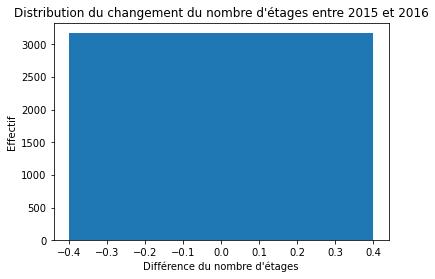

In [44]:
data_nb_floors['OSEBuildingID'] = data_nb_floors.index  # Pour utiliser count dans la fonction distrib_discrete_var
# distrib_nb_floors_diff: Distribution de la différence du nombre d'étage entre 2015 et 2016
distrib_nb_floors_diff = distrib_discrete_var(data_nb_floors, 'difference')
plot_distrib(distrib_nb_floors_diff, "Différence du nombre d'étages", "Effectif", 
             "Distribution du changement du nombre d'étages entre 2015 et 2016")

Aucune des propriétés des 2 bases de données ne change de nombre d'étages d'une année à l'autre. **Ici, on ne peut pas sélectionner de valeurs aberrantes.**

### PropertyGFABuilding(s)

Text(0.5, 1.0, 'Diagramme en boite de la surface totale')

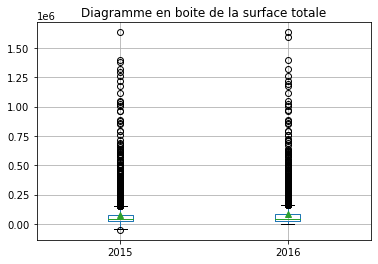

In [45]:
# data_gfa: Chaque colonne contient la surface brute des sols de chaque propriété pour une base de données 
data_gfa = pd.concat([data_2015['PropertyGFABuilding(s)'], data_2016['PropertyGFABuilding(s)']], axis=1)
data_gfa.columns = ['2015', '2016']
data_gfa.boxplot(showmeans=True)
plt.title("Diagramme en boite de la surface totale")

L'unité pour la surface n'est pas donnée, mais il s'agit ici probalement de mètres carrés. (1000000m2 = 1km2)

On observe qu'il y à des **valeurs nulles ou négatives: On va les supprimer**.

In [46]:
data_2015 = data_2015[data_2015['PropertyGFABuilding(s)'] > 0]
data_2016 = data_2016[data_2016['PropertyGFABuilding(s)'] > 0]

On va regarder la distribution de la surface des bâtiments pour chaque propriété, en discrétisant cette variable.

(0.0, 300.0)

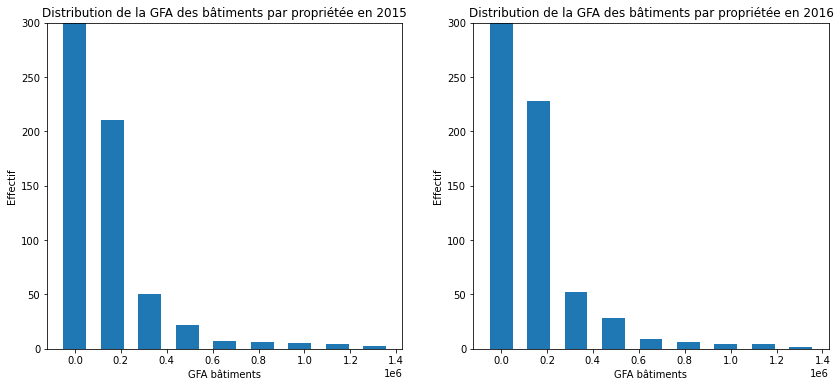

In [47]:
# max_gfa: Surface maximale sur les 2 années
max_gfa = max(data_2015['PropertyGFABuilding(s)'].max(), data_2016['PropertyGFABuilding(s)'].max())
# nb_bins: Nombre de catégories pour la discrétisation
nb_bins = 10
# bins: Liste des limites de chaque catégorie de surfaces 
bins = [max_gfa*i/nb_bins for i in range(nb_bins)]
# distrib_gfa_2015: Distribution de la surface des bâtiments avec les données de 2015
distrib_gfa_2015 = distrib_continuous_var(data_2015, 'PropertyGFABuilding(s)', bins, float)
plt.subplots(figsize=(14,6))
plt.subplot(1, 2, 1)
plot_distrib(distrib_gfa_2015, "GFA bâtiments", "Effectif", 
             "Distribution de la GFA des bâtiments par propriétée en 2015", {'width': 10**5})
plt.ylim(0, 300)
plt.subplot(1, 2, 2)
# distrib_gfa_2016: Distribution de la surface des bâtiments avec les données de 2016
distrib_gfa_2016 = distrib_continuous_var(data_2016, 'PropertyGFABuilding(s)', bins, float)
plot_distrib(distrib_gfa_2016, "GFA bâtiments", "Effectif",
             "Distribution de la GFA des bâtiments par propriétée en 2016", {'width': 10**5})
plt.ylim(0, 300)

À partir de 0.7 km2, il n'y à plus que très peu d'individus. On va les supprimer, car il y à sans doute parmi eux des valeurs fausses.

In [48]:
data_2015 = data_2015[data_2015['PropertyGFABuilding(s)'] < 7*10**5]
data_2016 = data_2016[data_2016['PropertyGFABuilding(s)'] < 7*10**5]

**On ne va pas vérifier que la somme des surfaces par type d'usage est bien égale à la somme des surfaces des bâtiments**. En effet, certaines surfaces peuvent avoir plusieurs usages et faire dépasser la somme. De plus, certains usages minoritaires peuvent ne pas êtres pris en compte.

### Longitude, Latitude

Text(0.5, 1.0, 'Coordonnées géographiques des propriétés en 2015')

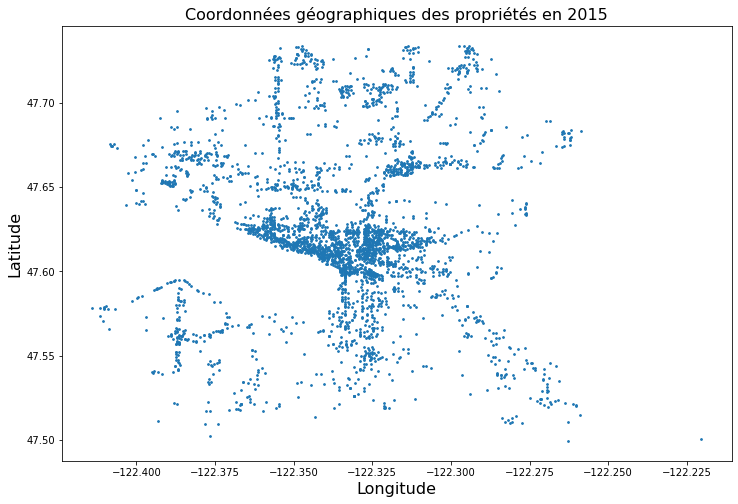

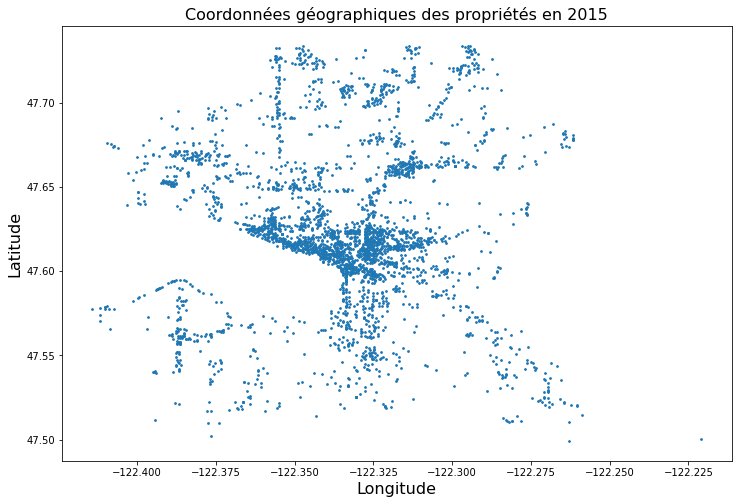

In [49]:
plt.figure(figsize=(12,8))
plt.scatter(data_2015['Longitude'], data_2015['Latitude'], s=3)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.title("Coordonnées géographiques des propriétés en 2015", fontsize=16)
plt.figure(figsize=(12,8))
plt.scatter(data_2016['Longitude'], data_2016['Latitude'], s=3)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.title("Coordonnées géographiques des propriétés en 2015", fontsize=16)

Les propriétés sembles à une distance raisonnables les unes des autres, et semblent respecter les frontières terrestres. **On va donc conserver toutes les valeurs des positions**.

###  SiteEnergyUse(kBty)

Text(0.5, 1.0, "Diagramme en boite de la consommation d'énergie")

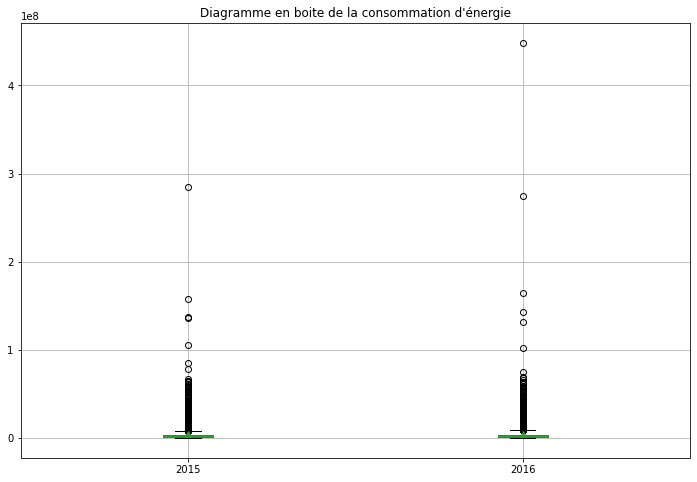

In [50]:
# data_energy_use: Contient dans chaque colonnes les consommation énergétiques de chaque année
data_energy_use = pd.concat([data_2015['SiteEnergyUse(kBtu)'], data_2016['SiteEnergyUse(kBtu)']], axis=1)
data_energy_use.columns = ['2015', '2016']
plt.figure(figsize=(12,8))
data_energy_use.boxplot(showmeans=True)
plt.title("Diagramme en boite de la consommation d'énergie")

Certains outliers sont considérablement éloignés des valeurs centrales. Voyons de quels individus il s'agit.

In [51]:
quantile_1 = data_2016['SiteEnergyUse(kBtu)'].quantile(0.25)
quantile_3 = data_2016['SiteEnergyUse(kBtu)'].quantile(0.75)
quantile_range = quantile_3-quantile_1
# upper_outliers: Outliers ayant des valeurs supérieures de consommation d'énergie
upper_outliers = data_2016[data_2016['SiteEnergyUse(kBtu)'] > quantile_3 + quantile_range*1.5]

In [52]:
# cols_outliers: Informations à afficher pour les outliers
cols_outliers = ['SiteEnergyUse(kBtu)', 'BuildingType', 'PrimaryPropertyType', 'PropertyGFABuilding(s)', 'PropertyName']
upper_outliers[cols_outliers].sort_values('SiteEnergyUse(kBtu)', ascending=False).head()

,SiteEnergyUse(kBtu),BuildingType,PrimaryPropertyType,PropertyGFABuilding(s),PropertyName
35,448385312.0,Campus,Mixed Use Property,494835,Plant 2 Site
558,274682208.0,NonResidential,Other,429405,WestinBuilding
3264,163945984.0,NonResidential,Hospital,374466,Virginia Mason Medical Center - 2149
167,143423024.0,NonResidential,Hospital,597519,Swedish Cherry Hill
340,131373880.0,Campus,Other,535947,Weintraub/Hutchinson/Thomas


**On ne trouve aucune information concernant 'plant 2 site'** sur internet, alors que cette propriété consomme 2x plus qu'un data center ou qu'un hopital... Il est mention de 'boeing plant 2', une usine d'aéronautique, mais elle a été démontée en 2010. **On va donc supprimer cet individu de nos données**.

In [53]:
data_2016 = data_2016[data_2016['PropertyName'] != 'Plant 2 Site']

On regarde à présent les **distributions des consommations d'énergie** sur les 2 années. On va donc discrétiser cette variable.

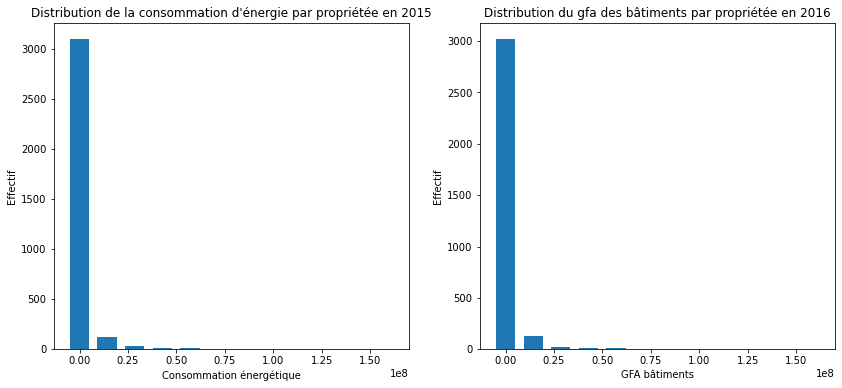

In [54]:
# max_nrj: Consommation maximale d'énergie en 2015 et en 2016
max_nrj = max(data_2015['SiteEnergyUse(kBtu)'].max(), data_2016['SiteEnergyUse(kBtu)'].max())
# nb_bins: Nombre de catégories pour la discrétisation
nb_bins = 20
# bins: Liste des limites des catégories de la discrétisation de la consommation d'énergie
bins = [max_nrj*i/nb_bins for i in range(nb_bins)]
# distrib_nrj_2015: Distribution de la consommation d'énergie avec les données de 2015
distrib_nrj_2015 = distrib_continuous_var(data_2015, 'SiteEnergyUse(kBtu)', bins, float)
plt.subplots(figsize=(14,6))
plt.subplot(1, 2, 1)
plot_distrib(distrib_nrj_2015, "Consommation énergétique", "Effectif", 
             "Distribution de la consommation d'énergie par propriétée en 2015", {'width':10**7})
# distrib_nrj_2016: Distribution de la consommation d'énergie avec les données de 2016
distrib_nrj_2016 = distrib_continuous_var(data_2016, 'SiteEnergyUse(kBtu)', bins, float)
plt.subplot(1, 2, 2)
plot_distrib(distrib_nrj_2016, "GFA bâtiments", "Effectif",
             "Distribution du gfa des bâtiments par propriétée en 2016", {'width': 10**7})

On supprime les valeurs trop extrêmes, qui sont minoritaires et qui peuvent fausser les résultats.

In [55]:
data_2015 = data_2015[data_2015['SiteEnergyUse(kBtu)'] < 3*10**7]
data_2016 = data_2016[data_2016['SiteEnergyUse(kBtu)'] < 3*10**7]

## TotalGHGEmissions

Text(0.5, 1.0, 'Diagramme en boite des émissions totales de gazs à effet de serre')

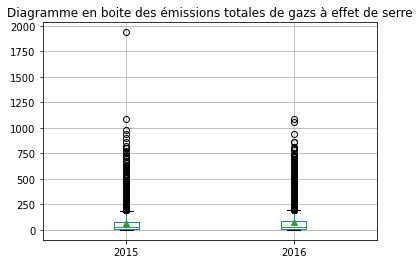

In [56]:
# data_ghg: Contient dans chaque colonne les masses de gazs à effet de serre émises pour chaque année
data_ghg = pd.concat([data_2015['TotalGHGEmissions'], data_2016['TotalGHGEmissions']], axis=1)
data_ghg.columns = ['2015', '2016']
data_ghg.boxplot(showmeans=True)
plt.title("Diagramme en boite des émissions totales de gazs à effet de serre")

Commençons par observer **quel est le plus grand émetteur**.

In [57]:
data_2015.sort_values('TotalGHGEmissions', ascending=False)[cols_outliers+['TotalGHGEmissions']].iloc[0]

SiteEnergyUse(kBtu)           28229320.0
BuildingType              NonResidential
PrimaryPropertyType                Hotel
PropertyGFABuilding(s)             61320
PropertyName                   HOTEL MAX
TotalGHGEmissions                1936.34
Name: 3, dtype: object

Il s'agit d'un hotel, qui ~2x plus que les autres hotels parmi les plus grands émetteurs. **C'est beaucoup, mais difficile de dire si c'est aberrant**, car on ne trouve pas de références sur le sujet. On sait que les hotels dans les transports maritimes de Seattle émettaient 35 tonnes de CO2 en 2016, mais cela ne nous permet pas de trancher.

Voyons à présent les **distributions de ses émissions**. Pour cela, on va discrétiser la variable associée.

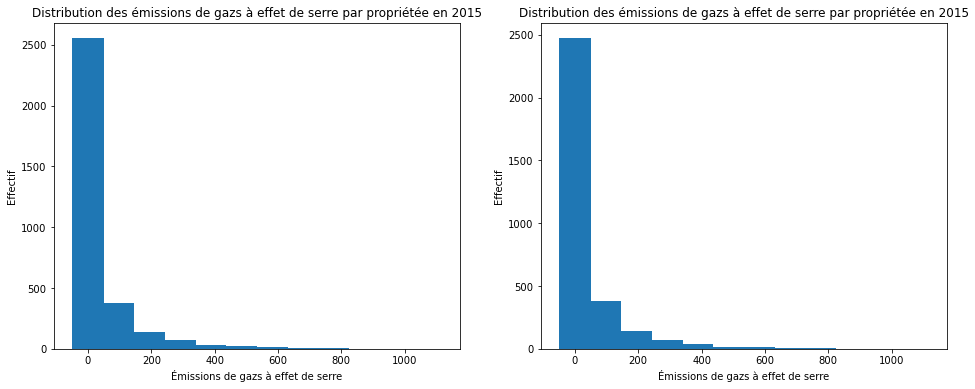

In [58]:
# max_ghg: Masse maximale de CO2 émise par une propriété en 2015 et en 2016
max_ghg = max(data_2015['TotalGHGEmissions'].max(), data_2016['TotalGHGEmissions'].max())
# nb_bins: Nombre de catégories pour la discrétisation.
nb_bins = 20
# bins: Liste des limites inférieures de chaque catégorie.
bins = [max_ghg*i/nb_bins for i in range(nb_bins)]
# distrib_ghg_2015: Distribution des masses de gazs à effet de serre émises en 2015
distrib_ghg_2015 = distrib_continuous_var(data_2015, 'TotalGHGEmissions', bins, float)
plt.subplots(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_distrib(distrib_ghg_2015, "Émissions de gazs à effet de serre", "Effectif", 
             "Distribution des émissions de gazs à effet de serre par propriétée en 2015", {'width':100})
plt.subplot(1, 2, 2)
# distrib_ghg_2016: Distribution des masses de gazs à effet de serre émises en 2016
distrib_ghg_2016 = distrib_continuous_var(data_2016, 'TotalGHGEmissions', bins, float)
plot_distrib(distrib_ghg_2016, "Émissions de gazs à effet de serre", "Effectif",
             "Distribution des émissions de gazs à effet de serre par propriétée en 2015", {'width':100})

**On supprime les émissions qui dépassent 600kg par an et les émissions nulles**.

In [59]:
data_2015 = data_2015[data_2015['TotalGHGEmissions'] < 600]
data_2016 = data_2016[data_2016['TotalGHGEmissions'] < 600]
data_2015 = data_2015[data_2015['TotalGHGEmissions'] > 0]
data_2016 = data_2016[data_2016['TotalGHGEmissions'] > 0]

### ENERGYSTARScore

Text(0.5, 1.0, 'Diagramme en boite des ENERGYSTARScores')

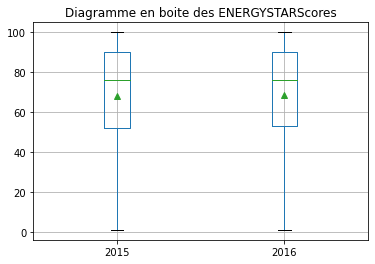

In [60]:
# data_score: Contient dans chaque colonne les ENERGYSTARScore pour chaque année
data_score = pd.concat([data_2015['ENERGYSTARScore'], data_2016['ENERGYSTARScore']], axis=1)
data_score.columns = ['2015', '2016']
data_score.boxplot(showmeans=True)
plt.title("Diagramme en boite des ENERGYSTARScores")

On observe que les scores sont dans les bonnes bornes et ne changent pas drastiquement entre les 2 années. **Les données sont probablement correctes**.

On s'intéresse maintenant aux **distributions des ENERGYSTARScores**.

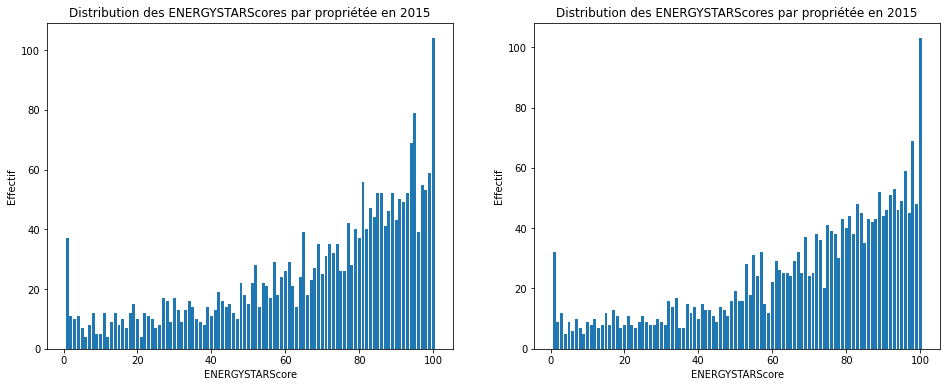

In [61]:
# distrib_score_2015: Distribution des ENERGYSTARScores en 2015
distrib_score_2015 = distrib_discrete_var(data_2015, 'ENERGYSTARScore')
plt.subplots(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_distrib(distrib_score_2015, "ENERGYSTARScore", "Effectif", 
             "Distribution des ENERGYSTARScores par propriétée en 2015")
plt.subplot(1, 2, 2)
# distrib_score_2016: Distribution des ENERGYSTARScores en 2016
distrib_score_2016 = distrib_discrete_var(data_2016, 'ENERGYSTARScore')
plot_distrib(distrib_score_2016, "ENERGYSTARScore", "Effectif",
             "Distribution des ENERGYSTARScores par propriétée en 2015")

On observe que **la distribution est relativement homogène**: Il n'y à pas plus de 100 individus sur un score. Cependant, on constate une certaine asymétrie vers la droite, avec plus de propriétés qui ont un bon score. Finalement, on ne voit **pas de valeurs qui se démarquent nettement du reste comme étant aberrantes**.

### LargestPropertyUseType

In [90]:
usetypes_2015 = data_2015['LargestPropertyUseType'].dropna().unique()

In [92]:
usetypes_2016 = data_2016['LargestPropertyUseType'].dropna().unique()

Les valeurs possibles sont correctes.

Voyons maintenant les différences entre les types d'activité possibles chaque année:

In [93]:
np.setdiff1d(usetypes_2015, usetypes_2016)

array(['Food Service', 'Hospital (General Medical & Surgical)',
       'Outpatient Rehabilitation/Physical Therapy',
       'Wholesale Club/Supercenter'], dtype=object)

In [94]:
np.setdiff1d(usetypes_2016, usetypes_2015)

array(['Prison/Incarceration'], dtype=object)

Il n'y à pas d'appellations différentes entre les bases de données.

## Valeurs manquantes

In [62]:
def filling_ratios(data, data_name, nb_to_display=10, percentage=True):
    """Retourne le taux de remplissage des variables d'une base de données."""
    print("Taux de remplissage des variables de %s:" % data_name)
    ratios_sorted = (data.count()/len(data_2015)).sort_values().iloc[:nb_to_display]
    ratios_sorted = ratios_sorted*100 if percentage else ratios_sorted
    print(ratios_sorted)

In [63]:
filling_ratios(data_2015, "2015", nb_to_display=10, percentage=True)
print()
filling_ratios(data_2016, "2016", nb_to_display=10, percentage=True)

Taux de remplissage des variables de 2015:
Comments                            0.218341
Outlier                             2.432938
YearsENERGYSTARCertified            2.838428
ThirdLargestPropertyUseTypeGFA     16.094822
ThirdLargestPropertyUseType        16.094822
SecondLargestPropertyUseTypeGFA    46.163444
SecondLargestPropertyUseType       46.163444
ENERGYSTARScore                    77.386151
LargestPropertyUseTypeGFA          96.163444
LargestPropertyUseType             96.163444
dtype: float64

Taux de remplissage des variables de 2016:
Comments                            0.000000
Outlier                             0.935745
YearsENERGYSTARCertified            3.087960
ThirdLargestPropertyUseType        16.344354
ThirdLargestPropertyUseTypeGFA     16.344354
SecondLargestPropertyUseType       48.066126
SecondLargestPropertyUseTypeGFA    48.066126
ENERGYSTARScore                    74.329382
ZipCode                            97.161572
LargestPropertyUseType             97.31753

Pour certaines de ces variables, avoir des valeurs manquantes n'est pas un problème. Il s'agit de:
- **Comments**: Les commentaires sont facultatifs
- **Outlier**: L'individu n'est pas forcémment un outlier
- **SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA**: La propriété peut avoir une activité unique.
- **ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA**: Même remarque que précédemment.

Il nous reste donc les variables suivantes:
- **YearsENERGYSTARCertified**
- **ENERGYSTARScore**
- **LargestPropertyUseType, LargestPropertyUseTypeGFA**: Pour celle-ci, on dispose de suffisamment de données

## Imputation

### 1- ENERGYSTARScore
On sait que cette variable dépend de l'activité de la propriété. Voyons si on a suffisamment d'individus pour chaque catégorie pour faire une régression par catégorie.

In [64]:
# data: Concaténation des données pour les 2 années pour avoir de plus grands échantillons
data = pd.concat([data_2015, data_2016], axis=0)

In [65]:
# vars_input: Variables d'entrées pour l'imputation 
vars_input = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)', 'Latitude', 
              'Longitude', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
data = data.dropna(subset=vars_input+['ENERGYSTARScore'])

In [66]:
samples_sizes = data.groupby('LargestPropertyUseType').count()['OSEBuildingID'].sort_values()

In [67]:
print("Effectifs par catégorie principale d'activité")
samples_sizes.sort_values(ascending=False).iloc[:15]

Effectifs par catégorie principale d'activité


LargestPropertyUseType
Multifamily Housing           2719
Office                         748
Non-Refrigerated Warehouse     285
K-12 School                    253
Retail Store                   155
Worship Facility               126
Hotel                          114
Distribution Center             81
Supermarket/Grocery Store       70
Senior Care Community           67
Medical Office                  63
Residence Hall/Dormitory        29
Refrigerated Warehouse          10
Parking                          8
Bank Branch                      8
Name: OSEBuildingID, dtype: int64

On observe qu'il y à certains types d'utilisation de propriété qui sont majoritaires. **Pour ces types qui ont un effectif suffisant, on peut essayer d'imputer l'ENERGYSTARScore**. On va le faire lorsqu'on a un échantillon de taille 50 ou plus

In [68]:
imputable_usetypes = samples_sizes[samples_sizes > 100]
imputable_usetypes = imputable_usetypes.index

On définit les entrées/sorties pour chaque type d'activité pour l'imputation.

In [69]:
# in_usetype: Dictionnaire avec les données d'entrée pour l'imputation étant donnée un type d'activité
in_usetype = {}
# in_usetype: Dictionnaire avec les données en sortie pour l'imputation étant donnée un type d'activité
out_usetype = {}
for usetype in imputable_usetypes:
    data_usetype = data[data['LargestPropertyUseType']==usetype]
    in_usetype[usetype] = data_usetype[vars_input]
    out_usetype[usetype] = data_usetype['ENERGYSTARScore']

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

On sépare nos données dans les dictionnaires en données de test et d'entrainement.

In [71]:
std_scale = StandardScaler()
for usetype in imputable_usetypes:
    in_usetype[usetype] = std_scale.fit_transform(in_usetype[usetype])
    in_train, in_test, out_train, out_test = train_test_split(in_usetype[usetype], out_usetype[usetype], 
                                                              test_size=0.2)
    in_usetype[usetype] = {}
    in_usetype[usetype]['train'] = in_train
    in_usetype[usetype]['test'] = in_test
    out_usetype[usetype] = {}
    out_usetype[usetype]['train'] = out_train
    out_usetype[usetype]['test'] = out_test

In [72]:
for usetype in imputable_usetypes:
    # rand_forest: Régression de forêt aléatoire
    rand_forest = GradientBoostingRegressor(n_estimators=15, max_depth=15, learning_rate=0.8)
    rand_forest.fit(in_usetype[usetype]['train'], out_usetype[usetype]['train'])
    score = rand_forest.score(in_usetype[usetype]['test'], out_usetype[usetype]['test'])
    print("score(%s): %.2f" % (usetype, score))

score(Hotel): -0.23
score(Worship Facility): 0.45
score(Retail Store): -0.43
score(K-12 School): 0.65
score(Non-Refrigerated Warehouse): 0.60
score(Office): 0.56
score(Multifamily Housing): 0.50


On obtiens d'assez mauvais scores (<=0.65), **on s'abstiendra donc d'imputer cette variable**. Sachant qu'elle est remplie à 75%, **les données disponibles seront suffisantes** pour entraîner nos modèles.

Expliquons plus en détails pourquoi **il n'est pas possible de faire un modèle pour tous les types d'activités**.

Pour cela, on va regarder **comment se concentrent les individus sur certains types d'activité**. Dans ce but, on va calculer l'indice de Gini des effectifs en fonction du type d'activité.

In [74]:
# nb_samples: Nombre de d'échantillons ou nombre d'activité primaires
nb_samples = len(samples_sizes)
# samp_sizes_cum_norm: Somme cumulée des tailles d'échantillon normalisée
samp_sizes_cum_norm = samples_sizes.cumsum()/samples_sizes.sum()
# integral: Intégrale sous la courbe étudiée
integral = (samp_sizes_cum_norm.sum() - (1+samp_sizes_cum_norm.iloc[0])/2)/nb_samples
# gini_index: Indice de Gini de la courbe en question
gini_index = 2*(0.5-integral)

Text(0, 0.5, "Somme cumulée des tailles d'échantillon normalisée")

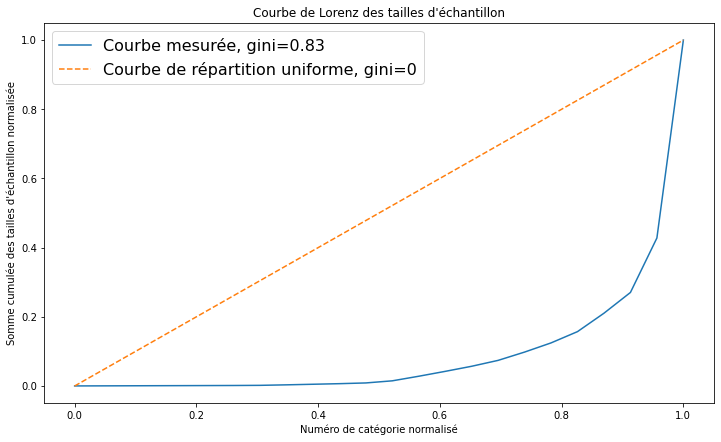

In [75]:
plt.figure(figsize = (12, 7))
plt.plot(np.linspace(0, 1, nb_samples), samp_sizes_cum_norm)  # Courbe étudiée
plt.plot(np.linspace(0, 1, nb_samples), np.linspace(0, 1, nb_samples), linestyle='--')  # Courbe modèle
plt.legend(["Courbe mesurée, gini=%.2f" % gini_index, "Courbe de répartition uniforme, gini=0"], fontsize=16)
plt.title("Courbe de Lorenz des tailles d'échantillon")
plt.xlabel("Numéro de catégorie normalisé")
plt.ylabel("Somme cumulée des tailles d'échantillon normalisée")

Avec un indice de gini de 0.83, il apparaît que **faire un modèle par type d'utilisation primaire des propriétés est impossible pour tous les types d'utilisation**. Or, le score Energy Star est basé sur un classement sur des propriétés au sein d'un même type d'utilisation primaire. On s'abstiendra donc de tenter de prédire ses valeurs sans prendre en compte cette information.

### 2- YearsENERGYSTARCertified

On peut faire les mêmes remarque que pour la variable ENERGYSTARScore. De plus, on a un taux de remplissage trop faible: <4% c.à.d ~100 individus qui remplissent cette variable.

### 3- LargestPropertyUseType

Pour cette variable, on a au moins 95% de taux de remplissage. On a donc suffisamment de données, sans avoir besoin de réaliser une imputation. 

## Fin du nettoyage
On supprime les lignes contenant des valeurs manquantes. Pour les types de propriétés secondaires et tertiaires, ansi que les surfaces, on considèrera que si elles ne sont pas remplies, c'est qu'il n'y en a pas.

In [76]:
# unfilled: Les colonnes dont on n'exige pas la complétion
unfilled = ['Comments', 'Outlier', 'YearsENERGYSTARCertified', 'ThirdLargestPropertyUseType',
            'ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
            'ENERGYSTARScore']
unfilled = pd.Index(unfilled)
# filled: Les colonnes dont on exige la completion
filled = data_2015.columns.difference(unfilled)

On supprime les individus qui n'ont pas de données pour les variables choisies, dans les 2 bases de données.

In [77]:
data_2015 = data_2015.dropna(subset=filled)
data_2016 = data_2016.dropna(subset=filled)

Finalement, on enregistre les bases de données nettoyées.

In [78]:
data_2015.to_csv('data_2015_cleaned.csv')
data_2016.to_csv('data_2016_cleaned.csv')

# Exploration

## Corrélations

### Position géographique - Consommation d'énergie

On va afficher les propriétés sur une carte, avec une couleur représentant leur consommation d'énergie.

In [79]:
# Les outliers positifs seront tous représentés par la même couleur
# lim_energyuse: Énergie au-delà de laquelle la couleur ne changera plus.
lim_energyuse = data_2015['SiteEnergyUse(kBtu)'].quantile(0.75)
lim_energyuse = lim_energyuse+1.5*(lim_energyuse-data_2015['SiteEnergyUse(kBtu)'].quantile(0.25))
# color_property: Liste des couleurs associés à la liste des propriétés
color_property = [1-energyuse/lim_energyuse for energyuse in data_2015['SiteEnergyUse(kBtu)']]
color_property = [[color]*3 if color>=0 else [1,0,0] for color in color_property]  # Définit la couleur RGB

Ici, plus la couleur est noire, plus la consommation énergétique est élevée, de façon proportionnelle. Seulement les outliers positifs sont tous représentés en rouge.

Text(0.5, 1.0, 'Coordonnées géographiques des propriétés')

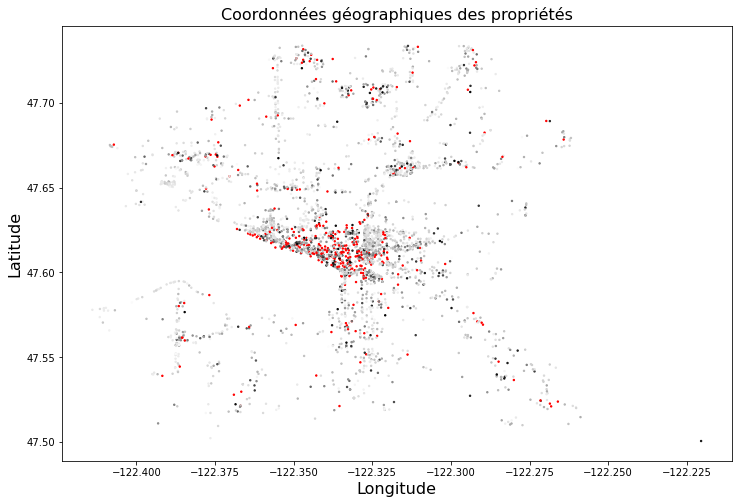

In [80]:
plt.figure(figsize=(12,8))
plt.scatter(data_2015['Longitude'], data_2015['Latitude'], s=2, color=color_property)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.title("Coordonnées géographiques des propriétés", fontsize=16)

On observe que **plus il y à de propriétés concentrées dans une zone, plus il y en à parmi elles qui consomment beaucoup d'énergie**. Par exemple, ici, la majorité des outliers sont concentrés au centre de la carte: là où il y à le plus de propriétés.

### GFA - EnergyUse

Text(0, 0.5, 'SiteEnergyUse(kBtu)')

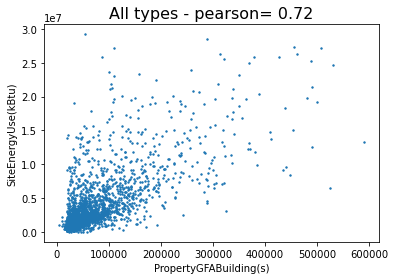

In [81]:
# data_nonan: Ne contient pas de valeurs manquantes pour les varibles étudiées ici
data_nonan = data_2015.dropna(subset=['PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)'])
gfa, nrj = data_nonan['PropertyGFABuilding(s)'], data_nonan['SiteEnergyUse(kBtu)']
plt.scatter(gfa, nrj, s=2)
plt.title("%s - pearson= %.2f" % ("All types", pearsonr(gfa, nrj)[0]), fontsize=16)
plt.xlabel("PropertyGFABuilding(s)")
plt.ylabel("SiteEnergyUse(kBtu)")   

La corrélation n'est pas négligeable mais pas tout à fait nette.
Voyons si en étudiant la corrélation par type de bâtiment, on obtient des coefficients plus élevés.   
Pour cela, voyons si les effectifs sont suffisants:

In [82]:
data_2015.groupby('BuildingType').count()['OSEBuildingID']

BuildingType
Campus                    12
Multifamily HR (10+)      94
Multifamily LR (1-4)     979
Multifamily MR (5-9)     535
NonResidential          1304
Nonresidential COS        62
SPS-District K-12         89
Name: OSEBuildingID, dtype: int64

La catégorie campus manque un peu de données, mais effectuons les régressions pour voir:

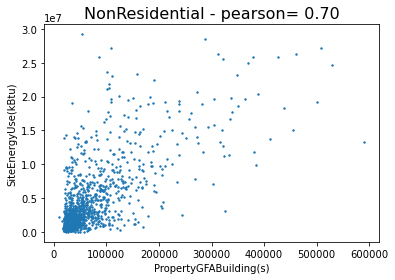

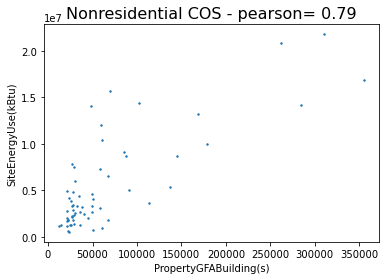

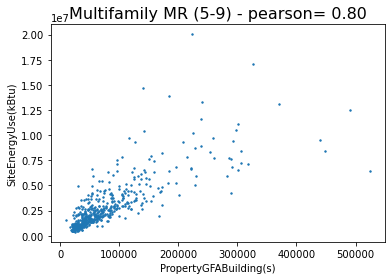

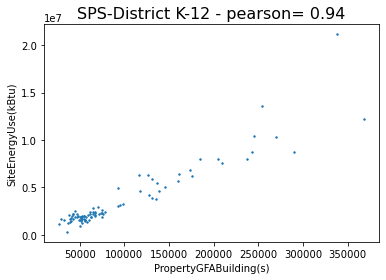

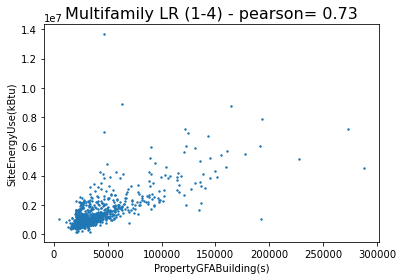

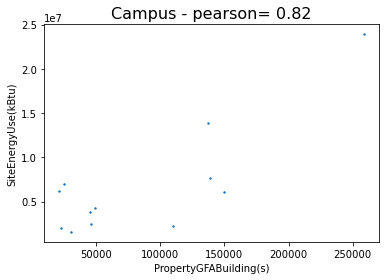

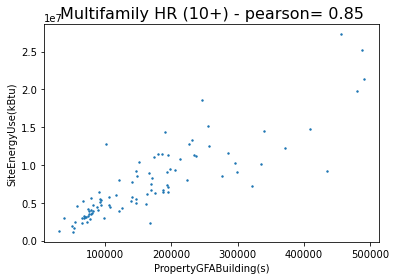

In [83]:
# data_per_buildtype: Contient dans chaque élément, les données d'un type de bâtiment.
data_per_buildtype = []
# On commence par construire data_per_buildtype...
for buildtype in data_nonan['BuildingType'].unique():
    data_per_buildtype.append(data_nonan[data_nonan['BuildingType'] == buildtype])

# ... Et on affiche le graphique correspondant pour chaque type de bâtiment
for ind_data, buildtype in enumerate(data_nonan['BuildingType'].unique()):
    data_buildtype = data_per_buildtype[ind_data]
    plt.subplots()
    gfa, nrj = data_buildtype['PropertyGFABuilding(s)'], data_buildtype['SiteEnergyUse(kBtu)']
    plt.scatter(gfa, nrj, s=2)
    plt.title("%s - pearson= %.2f" % (buildtype, pearsonr(gfa, nrj)[0]), fontsize=16)
    plt.xlabel("PropertyGFABuilding(s)")
    plt.ylabel("SiteEnergyUse(kBtu)")

Le coefficient de corrélation est dans les bornes \[0.7; 0.93\]. La corrélation est significative, mais ne permet pas d'anticiper les consommations d'énergie pour tous les types de bâtiments.   
On peut supposer qu'il existe d'autres facteurs à prendre en compte pour que la corrélation soit valide. 

### TotalGHGEmissions - ENERGYSTARTScore

Ici, on se limitera aux propriété d'un seul type d'activité: Celui avec l'effectif le plus grand.

Text(0, 0.5, 'TotalGHGEmissions')

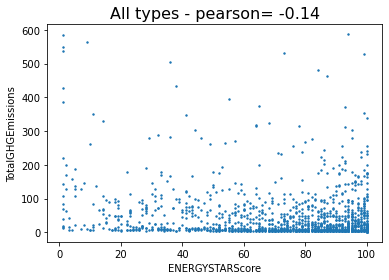

In [453]:
# data_nonan: Ne contient pas de valeurs manquantes pour les varibles étudiées ici
data_nonan = data_2015.dropna(subset=['ENERGYSTARScore', 'TotalGHGEmissions'])
# On se limite à un type d'activité.
data_nonan = data_nonan[data_nonan['LargestPropertyUseType'] == 'Multifamily Housing']
score, ghg = data_nonan['ENERGYSTARScore'], data_nonan['TotalGHGEmissions']
plt.scatter(score, ghg, s=2)
plt.title("%s - pearson= %.2f" % ("All types", pearsonr(score, ghg)[0]), fontsize=16)
plt.xlabel("ENERGYSTARScore")
plt.ylabel("TotalGHGEmissions")  

On observe qu'on peut avoir de fortes émissions et un ENERGYSTARScore faible et inversement. **On n'observe pas de corrélation entre l'ENERGYSTARScore les émissions de gazs à effet de serre**.   
En effet, cela était prévisible: Ce score dépend des performances des entreprises qui ont la même activité, la même taille... **Il s'agit plus de l'efficacité énergétique que de la quantité d'énergie**, et donc il n'est pas étonnant qu'il n'y ait pas de corrélation.

On soupçonne cependant des tendances à mesure que le score augmente. **Voyons ce que cela donne avec des diagrammes en boîte.**

Text(0.5, 1.0, "Diagrammes en boîte des émissions de gazs à effet de serre en fonction de l'ENERGYSTARScore")

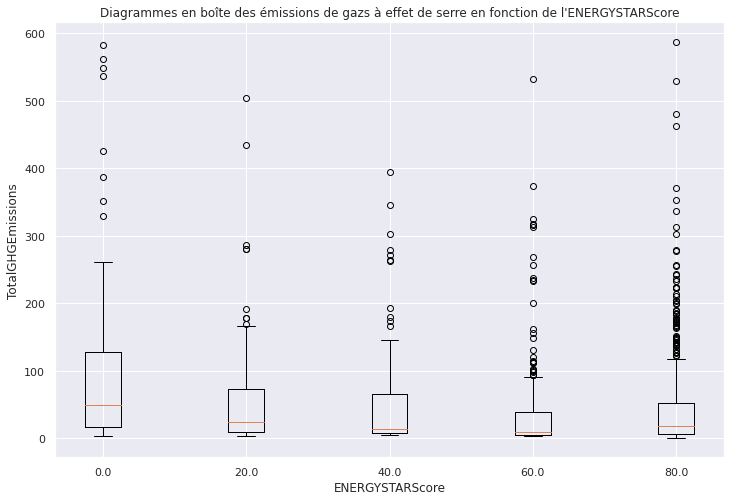

In [475]:
bins = [i*10 for i in range(0, 11, 2)]
data_nonan = data_2015.dropna(subset=['ENERGYSTARScore', 'TotalGHGEmissions'])
data_nonan = data_nonan[data_nonan['LargestPropertyUseType'] == 'Multifamily Housing']
data_nonan['ENERGYSTARScore'] = pd.cut(data_nonan['ENERGYSTARScore'], bins)
data_nonan['ENERGYSTARScore'] = data_nonan['ENERGYSTARScore'].map(get_left_interval)
data_nonan['ENERGYSTARScore'] = data_nonan['ENERGYSTARScore'].astype(float)
scores = data_nonan['ENERGYSTARScore'].unique()
vectors_ghg = []
for score in scores:
    vector_ghg = data_nonan[data_nonan['ENERGYSTARScore'] == score]['TotalGHGEmissions']
    vectors_ghg.append(vector_ghg)
plt.figure(figsize=(12,8))
plt.boxplot(vectors_ghg, positions=scores, widths = 5)
plt.ylabel("TotalGHGEmissions")
plt.xlabel("ENERGYSTARScore")
plt.title("Diagrammes en boîte des émissions de gazs à effet de serre en fonction de l'ENERGYSTARScore")

Effectivement, on constate que **les points se concentrent vers le bas du graphe à mesure que le score augmente**.

## Analyse des Composantes Pricipales

In [84]:
# cols_quanti: Colonnes des variables quantitatives à analyser dans l'acp
cols_quanti = ['YearBuilt', 'NumberofFloors', 'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
               'TotalGHGEmissions']

**On a supprimé le nombre de bâtiments des variables étudiées dans l'ACP**, car lorsqu'on l'inclu dans l'analyse, un axe lui est dédié: Elle y est fortement corrélé et les autres variables très peu.

In [85]:
# data_acp: Données pour l'ACP
data_acp = pd.concat([data_2015, data_2016])
data_acp = data_acp[cols_quanti]
data_acp = data_acp.dropna(subset=pd.Index(cols_quanti))

### Centrage-réduction

In [86]:
values_scaled = preprocessing.StandardScaler().fit_transform(data_acp.values)

In [87]:
# n_components_values: Liste des nombres de composantes principales à tester
n_components_values = np.arange(3,len(cols_quanti)+1)
# intertia_for_nb_comps: Dictionnaire de l'inertie pour un nombre de composantes principales
inertia_per_nb_comps = {}
for n_components in n_components_values:
    pca = decomposition.PCA(n_components=n_components)
    values_projected = pca.fit_transform(values_scaled)
    scree = pca.explained_variance_ratio_*100
    inertia_per_nb_comps[n_components] = sum(scree)

In [88]:
print("Pourcentage de l\'inertie totale en fonction du nombre de composantes principales")
pd.DataFrame(data=inertia_per_nb_comps, index=pd.Index(['Pourcentage de l\'inertie totale']))

Pourcentage de l'inertie totale en fonction du nombre de composantes principales


,3,4,5,6
Pourcentage de l'inertie totale,81.878962,92.265827,97.600928,100.0


On choisi le nombre de composantes principales de façon à **conserver au moins 90% de l'inertie du système**.

In [89]:
n_components = 4

In [90]:
# pca: Contient l'objet pca de scikit-learn
pca = decomposition.PCA(n_components=n_components)
# values_projected: Projection des individus.
values_projected = pca.fit_transform(values_scaled)

### Diagramme des éboulis

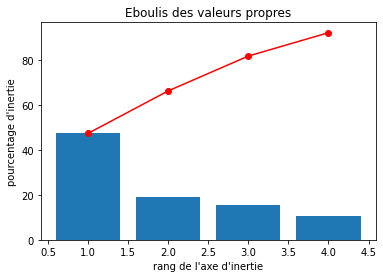

In [91]:
# scree: Contient les pourcentages de l'inertie pour chaque composante 
scree = pca.explained_variance_ratio_*100
# On numérote chaque composante et on affiche ce pourcentage dans un histogramme
plt.bar(np.arange(len(scree))+1, scree)
# On affiche aussi la somme cumulée des pourcentage d'inertie contenue dans chaque composante
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On constate que **le 1er axe représente environ la moité de l'inertie du système**, ce qui est considérable.

### Cercles des corrélations

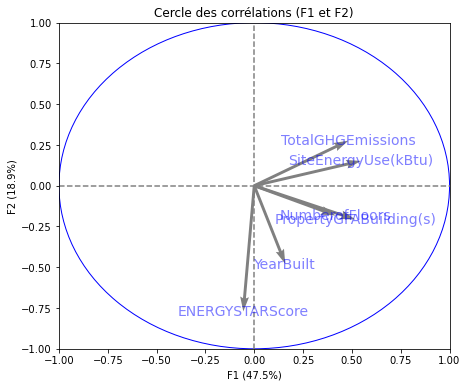

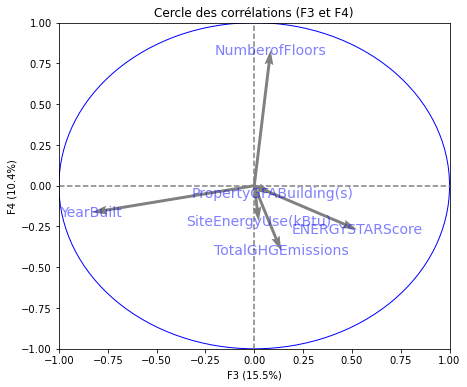

In [92]:
# Les données sont centrées-réduites dont les vecteurs sont normés i.e sur [-1,1]
xmin, xmax, ymin, ymax = -1, 1, -1, 1

def display_corr_circle(d1, d2, pca, labels):
    # pcs: La composition linéaire de chacune des composante principale en fonction de chaque variable
    pcs = pca.components_
    # On crée la figure qui va contenir tous les cercles
    fig = plt.figure(figsize=(7,6))
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
               pcs[d1,:], pcs[d2,:],
               angles='xy', scale_units='xy', scale=1, color="grey")
    # On parcours les segments pour les annoter
    for i, (x, y) in enumerate(pcs[[d1,d2]].T):
        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', color="blue", alpha=0.5)
    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    # On crée un cercle de centre (0,0) et de rayon 1, contenant tous les segments
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
    # plt.gca: Permet d'obtenir l'objet Axes de la figure courante, pour ajouter le cercle
    plt.gca().add_artist(circle)
    # affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')
    plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))

for d1, d2 in [(0, 1), (2, 3)]:
    display_corr_circle(d1, d2, pca, cols_quanti)

plt.show(block=False)

Voyons les **compositions de nos axes principaux**.

In [93]:
pd.DataFrame(data=pca.components_, columns=cols_quanti, index = [str("F%d" % i) for i in range(1, n_components+1)])

,YearBuilt,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
F1,0.158906,0.416736,0.517264,-0.056043,0.546217,0.481689
F2,-0.479703,-0.182672,-0.206739,-0.770962,0.152059,0.276170
F3,-0.829803,0.084123,0.091306,0.525828,0.023219,0.137767
F4,-0.163574,0.831690,-0.046442,-0.268908,-0.218613,-0.399094


Plus la propriété est grande, elle consomme de l'énergie et émet des gazs à effet de serre, plus la propriété est avancée sur l'axe F1. On peut faire l'hypothèse que **l'axe F1 représente le caractère écologique d'une propriété**.

En revanche, on constate que l'ENERGYSTARScore ne pèse presque pas sur cet axe, ce qui est surprenant.

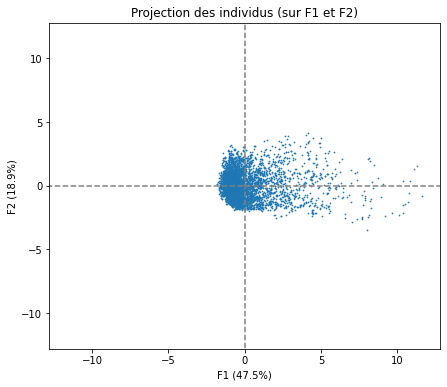

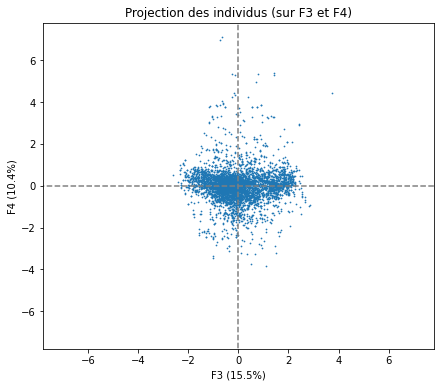

In [94]:
def display_factorial_plane(d1, d2, pca, labels=None, boundary=None):
    # initialisation de la figure   
    fig = plt.figure(figsize=(7,6))
    # affichage des points
    plt.scatter(values_projected[:, d1], values_projected[:, d2], alpha=1, s=0.5)

    if not (labels is None):
        for i,(x,y) in enumerate(values_projected[:,[d1,d2]]):
            plt.text(x, y, labels[i], fontsize='14', ha='center',va='center')

    # détermination des limites du graphique
    if boundary is None:
        boundary = np.max(np.abs(values_projected[:, [d1,d2]])) * 1.1
    plt.xlim([-boundary,boundary])
    plt.ylim([-boundary,boundary])

    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

    plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
    
for d1, d2 in [(0, 1), (2, 3)]:
    display_factorial_plane(d1, d2, pca)

plt.show(block=False)

- Sur la 1ère figure, on voit une dispersion des données vers la droite du graphe (ver les hautes consommations, émissions et tailles des bâtiments)
- Sur la 2ème, une dispersion sur le nombre d'étage.